<a href="https://colab.research.google.com/github/davidomosh/davidomosh/blob/main/HKS_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing necessary libraries
import nltk
!pip install vaderSentiment
!pip install textblob
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pandas as pd
from textblob import Word
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Loading the dataset
data=pd.read_csv("/content/drive/MyDrive/fb data.csv", encoding='latin-1') # Try loading with Latin-1 encoding

In [ ]:
print(data.head())

   commentsCount                      date  likesCount  \
0            NaN  2023-10-02T06:23:01.000Z           0   
1            1.0  2023-09-28T05:15:17.000Z           0   
2            1.0  2023-09-27T13:35:39.000Z           0   
3            NaN  2023-09-27T21:42:23.000Z           0   
4            NaN  2023-09-27T20:15:04.000Z           0   

                                           postTitle           profileName  \
0  Yes, it's possible to apply for a birth certif...     Virginiah Wanjiku   
1  Yes, it's possible to apply for a birth certif...  Mugusi Macdonald Mac   
2  Yes, it's possible to apply for a birth certif...      Purity K Adagala   
3  Yes, it's possible to apply for a birth certif...         Ronald Ragnar   
4  Yes, it's possible to apply for a birth certif...            Edu Ng'ash   

                                                text  
0                          May b a week or two weeks  
1  I am a witness, I applied for my child's birth...  
2  When you have 

In [ ]:
data.columns

Index(['commentsCount', 'date', 'likesCount', 'postTitle', 'profileName',
       'text'],
      dtype='object')

In [ ]:
# Check for missing values in each column
missing_values = data.isnull().sum()
df_cleaned=data.dropna(inplace=True)
print(missing_values)



commentsCount    1611
date                0
likesCount          0
postTitle         477
profileName         0
text               69
dtype: int64


In [ ]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])
print(data.head())

    commentsCount                      date  likesCount  \
1             1.0 2023-09-28 05:15:17+00:00           0   
2             1.0 2023-09-27 13:35:39+00:00           0   
5             3.0 2023-09-27 13:49:40+00:00           0   
12            1.0 2023-09-27 13:39:12+00:00           0   
23            3.0 2022-12-08 16:50:45+00:00           0   

                                            postTitle  \
1   Yes, it's possible to apply for a birth certif...   
2   Yes, it's possible to apply for a birth certif...   
5   Yes, it's possible to apply for a birth certif...   
12  Yes, it's possible to apply for a birth certif...   
23  We are always happy to serve you. Welcome to H...   

                           profileName  \
1                 Mugusi Macdonald Mac   
2                     Purity K Adagala   
5                          Mary Akinyi   
12                       Hamson Bahati   
23  Climbzone Cooling Services Limited   

                                                 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   commentsCount  602 non-null    float64
 1   date           2213 non-null   object 
 2   likesCount     2213 non-null   int64  
 3   postTitle      1736 non-null   object 
 4   profileName    2213 non-null   object 
 5   text           2144 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 103.9+ KB


In [ ]:
#Pre-Processing the text
def cleaning(df, stop_words):
    # Assuming your text data is in a column named 'text' (change this if needed)
    # Handle potential float values by converting them to strings
    df['sentences'] = df['text'].astype(str).apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['sentences'] = df['sentences'].str.replace('d', '')
    # Removing stop words
    df['sentences'] = df['sentences'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['sentences'] = df['sentences'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x) for x in x.split()]))
    return df

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() # Initialize the lemmatizer
data_cleaned = cleaning(data, stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
print(data_cleaned.head())

   commentsCount                      date  likesCount  \
0            NaN  2023-10-02T06:23:01.000Z           0   
1            1.0  2023-09-28T05:15:17.000Z           0   
2            1.0  2023-09-27T13:35:39.000Z           0   
3            NaN  2023-09-27T21:42:23.000Z           0   
4            NaN  2023-09-27T20:15:04.000Z           0   

                                           postTitle           profileName  \
0  Yes, it's possible to apply for a birth certif...     Virginiah Wanjiku   
1  Yes, it's possible to apply for a birth certif...  Mugusi Macdonald Mac   
2  Yes, it's possible to apply for a birth certif...      Purity K Adagala   
3  Yes, it's possible to apply for a birth certif...         Ronald Ragnar   
4  Yes, it's possible to apply for a birth certif...            Edu Ng'ash   

                                                text  \
0                          May b a week or two weeks   
1  I am a witness, I applied for my child's birth...   
2  When you ha

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(data_cleaned['sentences'])
import tensorflow as tf
import numpy as np
X_coo = X.tocoo()
indices = np.vstack((X_coo.row, X_coo.col)).T
X_sparse_tf = tf.sparse.SparseTensor(indices=indices, values=X_coo.data, dense_shape=X_coo.shape)
X_sparse_tf= tf.sparse.reorder(X_sparse_tf)
X_sparse_tf.shape
#save matrix using pickle
import pickle
with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(X, f)





In [ ]:
#loading back the mattrix
with open('tfidf_matrix.pkl', 'rb') as f:
        X = pickle.load(f)

In [ ]:
#sentimental analysis using textblob
from textblob import TextBlob
import pandas as pd

def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming 'data' is your DataFrame with 'text' column
data['polarity'] = data['text'].apply(analyze_sentiment)
data['sentiment_class'] = data['polarity'].apply(classify_sentiment)

print(data['sentiment_class'].value_counts())

sentiment_class
Neutral     223
Positive    145
Negative     56
Name: count, dtype: int64


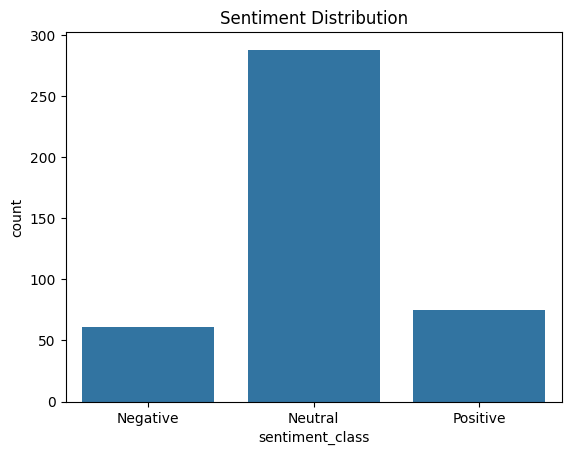

In [ ]:
#visualize sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='sentiment_class', data=data)
plt.title('Sentiment Distribution')
plt.show()



In [ ]:
#encode sentiment labels
sentiment_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
data['sentiment_encoded'] = data['sentiment_class'].map(sentiment_mapping)
y=pd.get_dummies(data['sentiment_encoded']).values

In [ ]:
#tokenization
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(data_cleaned['sentences'].values)
X = tokenizer.texts_to_sequences(data_cleaned['sentences'].values)
X = pad_sequences(X)



In [ ]:
#train and test sets split
Y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
#buid model
Embedding_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_words,Embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 87, 128)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 87, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 1)                 197       
                                                                 
Total params: 894997 (3.41 MB)
Trainable params: 894997 (3.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
#train the lstm model
epochs = 5
batch_size = 32
verbose=1
history=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/5
11/11 [==============================] - 13s 514ms/step - loss: 0.3546 - accuracy: 0.6342 - val_loss: 0.1044 - val_accuracy: 0.7294
Epoch 2/5
11/11 [==============================] - 10s 986ms/step - loss: 0.1432 - accuracy: 0.6667 - val_loss: 0.1092 - val_accuracy: 0.7294
Epoch 3/5
11/11 [==============================] - 8s 772ms/step - loss: 0.1367 - accuracy: 0.6667 - val_loss: 0.0934 - val_accuracy: 0.7294
Epoch 4/5
11/11 [==============================] - 8s 680ms/step - loss: 0.1369 - accuracy: 0.6667 - val_loss: 0.0965 - val_accuracy: 0.7294
Epoch 5/5
11/11 [==============================] - 5s 416ms/step - loss: 0.1333 - accuracy: 0.6667 - val_loss: 0.0928 - val_accuracy: 0.7294


In [ ]:
#evaluating the model
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
print('Score: %.2f'%(score))
print('Validation accuracy: %.2f'%(acc))



3/3 [==============================] - 0s 67ms/step - loss: 0.0928 - accuracy: 0.7294
Score: 0.09
Validation accuracy: 0.73


<function matplotlib.pyplot.show(close=None, block=None)>

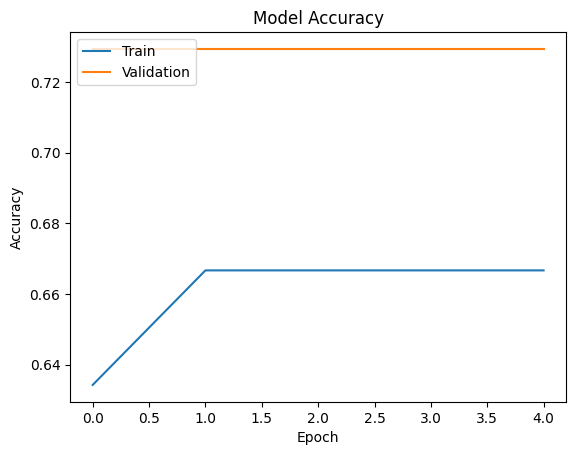

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show

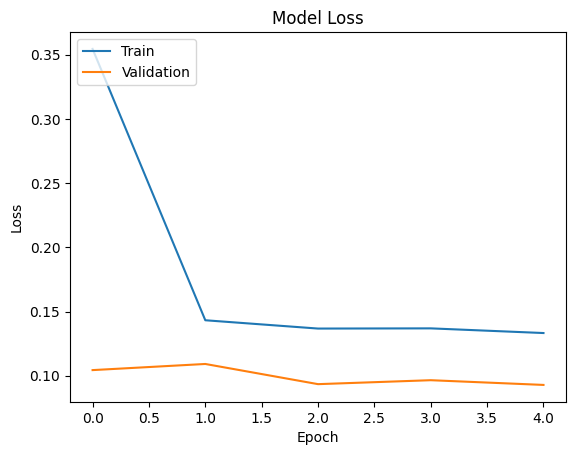

In [ ]:
#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')